In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Data Analysis
import pandas as pd
import numpy as np
from IPython.core.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Learning
import torch
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Activation, Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications.vgg19 import VGG19

# Miscellaneous
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
# Loading TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Save the events of notebook
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Colab Notebooks/Image Classification/data/logs')

In [48]:
# Dashboard
# %tensorboard --logdir logs

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available.")

GPU is available: Tesla T4


In [7]:
image_class = os.listdir('/content/drive/MyDrive/Colab Notebooks/Image Classification/data/train_images')
image_class

['onion', 'fork', 'book', 'apple']

### **Preprocessing**

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions
)

# instantiate image data generator
data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

In [9]:
# data = data_gen.flow_from_directory(
#     directory='/content/drive/MyDrive/Colab Notebooks/Image Classification/data/train_images', 
#     class_mode="categorical", 
#     classes=image_class, 
#     batch_size=400, 
#     target_size=(224,224)
# )

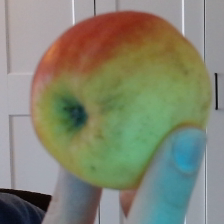

In [10]:
# View Image
Image('/content/drive/MyDrive/Colab Notebooks/Image Classification/data/train_images/apple/09-29-10-965320.png')

In [11]:
batch_size = 400
img_height = 224
img_width = 224

### **Split Dataset**

In [12]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Image Classification/data/train_images'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 320 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


In [14]:
def shape_ds(ds):
  '''
  Give's shape of dataset
  '''
  for image_batch, labels_batch in ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

shape_ds(train_ds)

(320, 224, 224, 3)
(320,)


### **EDA**

In [15]:
class_names = train_ds.class_names
print(class_names)

['apple', 'book', 'fork', 'onion']


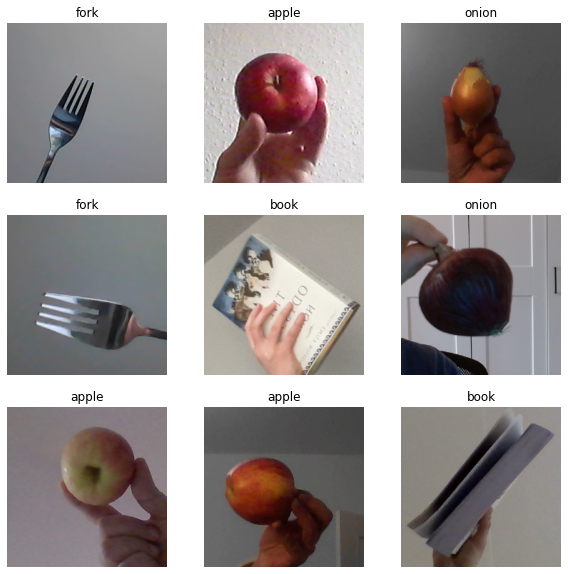

In [16]:
def plotImages(ds):
  '''
  Plot's Image in grid Form 
  '''
  plt.figure(figsize=(10, 10))

  # take() is used to form a dataset with maximum count foremost items out of the stated dataset
  for images, labels in ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

plotImages(train_ds)

### **Standardize the data**


> Both methods are used for normalization of images between 0 & 1




In [17]:
autotuned = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotuned)
val_ds = val_ds.cache().prefetch(buffer_size=autotuned)

In [18]:
# normalized_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalized_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

### **Deep Model Building**


> Using base model VGG19



In [19]:
base_model_vgg19 = tf.keras.applications.VGG19(
  weights='imagenet', 
  include_top=False, 
  pooling='max', 
  input_shape=(224,224,3)
)

80134624/80134624 [==============================] - 0s 0us/step


In [20]:
base_model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
# freeze base model
base_model_vgg19.trainable = False

In [22]:
def build_model():
    '''
    Complie's a model by stacking dense layers on top of base model 
    '''
    
    num_classes = 4

    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(base_model_vgg19)
    
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=256, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            # units=4,
            len(image_class),
            # num_classes,
            activation='softmax'
        )
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

### **Model Training**

In [23]:
# Instantiate model
model = build_model()

In [24]:
# Early stopping
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

**Note**:

Shape error arise's because `categorical_crossentropy` works on `one-hot encoded target`, while `sparse_categorical_crossentropy` works on `integer target`.

In [25]:
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100,
  batch_size=32,
  verbose=2, 
  callbacks=[stop_early],
  shuffle=True
)

Epoch 1/100
1/1 - 60s - loss: 38.4600 - categorical_accuracy: 0.3781 - val_loss: 23.6394 - val_categorical_accuracy: 0.4250 - 60s/epoch - 60s/step
Epoch 2/100
1/1 - 2s - loss: 41.2442 - categorical_accuracy: 0.3500 - val_loss: 20.6409 - val_categorical_accuracy: 0.4625 - 2s/epoch - 2s/step
Epoch 3/100
1/1 - 2s - loss: 36.4210 - categorical_accuracy: 0.3875 - val_loss: 17.9314 - val_categorical_accuracy: 0.4500 - 2s/epoch - 2s/step
Epoch 4/100
1/1 - 2s - loss: 32.8572 - categorical_accuracy: 0.3812 - val_loss: 15.4688 - val_categorical_accuracy: 0.4250 - 2s/epoch - 2s/step
Epoch 5/100
1/1 - 2s - loss: 32.0602 - categorical_accuracy: 0.3313 - val_loss: 13.3894 - val_categorical_accuracy: 0.3875 - 2s/epoch - 2s/step
Epoch 6/100
1/1 - 2s - loss: 29.5119 - categorical_accuracy: 0.3469 - val_loss: 11.8665 - val_categorical_accuracy: 0.3875 - 2s/epoch - 2s/step
Epoch 7/100
1/1 - 2s - loss: 28.7020 - categorical_accuracy: 0.2594 - val_loss: 10.7024 - val_categorical_accuracy: 0.3625 - 2s/epoch

### **Training History**


1.   Losses
2.   Epochs



In [26]:
# losses in the training history
losses = pd.DataFrame(model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

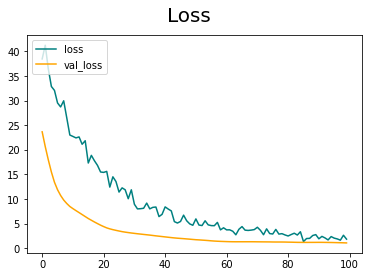

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### **Model Evaluation**

In [28]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images',
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 66 files belonging to 4 classes.


In [29]:
class_names = test_ds.class_names
print(class_names)

['apple', 'book', 'fork', 'onion']


In [30]:
shape_ds(test_ds)

(66, 224, 224, 3)
(66,)


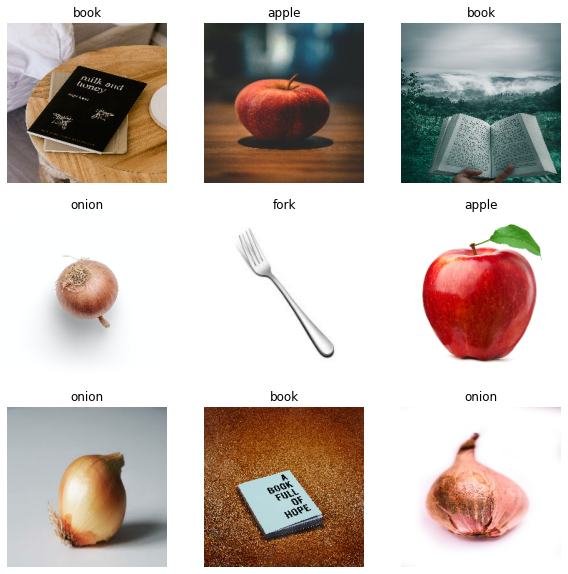

In [31]:
plotImages(test_ds)

In [38]:
# Get predicted probabilities for some test data
probs = model.predict(test_ds, verbose=0)

In [42]:
# Get the predicted class index for each sample
predicted_classes = tf.argmax(probs, axis=1)

In [43]:
# Get the list of image filenames from the test dataset
image_names = test_ds.file_paths

In [44]:
# Display the predicted probabilities and class for each image
for i, (proba, predicted_class) in enumerate(zip(probs, predicted_classes)):
    print(f"Image {image_names[i]}: Predicted Class {predicted_class} with Probability {proba[predicted_class]}")

Image /content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images/onion/erda-estremera-tnhZUDFpKyw-unsplash.jpg: Predicted Class 3 with Probability 0.9434925317764282
Image /content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images/onion/onion_1.jpeg: Predicted Class 1 with Probability 1.0
Image /content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images/apple/amit-lahav-rxN2MRdFJVg-unsplash.jpg: Predicted Class 0 with Probability 1.0
Image /content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images/fork/images-5.jpeg: Predicted Class 3 with Probability 1.0
Image /content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images/apple/apple_6.jpg: Predicted Class 2 with Probability 1.0
Image /content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images/onion/onion_2.jpeg: Predicted Class 1 with Probability 1.0
Image /content/drive/MyDrive/Colab Notebooks/Image Classification/data/test_images/b

In [45]:
# Display the predicted probabilities and class for each sample
for i, (proba, predicted_class) in enumerate(zip(probs, predicted_classes)):
    print(f"Sample {i}: Predicted Class {predicted_class} with Probability {proba[predicted_class]}")

Sample 0: Predicted Class 3 with Probability 0.9434925317764282
Sample 1: Predicted Class 1 with Probability 1.0
Sample 2: Predicted Class 0 with Probability 1.0
Sample 3: Predicted Class 3 with Probability 1.0
Sample 4: Predicted Class 2 with Probability 1.0
Sample 5: Predicted Class 1 with Probability 1.0
Sample 6: Predicted Class 0 with Probability 1.0
Sample 7: Predicted Class 2 with Probability 1.0
Sample 8: Predicted Class 3 with Probability 1.0
Sample 9: Predicted Class 1 with Probability 1.0
Sample 10: Predicted Class 1 with Probability 1.0
Sample 11: Predicted Class 0 with Probability 1.0
Sample 12: Predicted Class 2 with Probability 1.0
Sample 13: Predicted Class 1 with Probability 1.0
Sample 14: Predicted Class 2 with Probability 1.0
Sample 15: Predicted Class 2 with Probability 1.0
Sample 16: Predicted Class 2 with Probability 0.9999064207077026
Sample 17: Predicted Class 3 with Probability 0.9788371324539185
Sample 18: Predicted Class 1 with Probability 1.0
Sample 19: Pred

### **Save Model**

In [49]:
# Save your model
model.save('my_model.h5')